# kNN models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from seaborn import set_style

set_style("whitegrid")

In [2]:
df = pd.read_csv("../data/final_dataframes/main_training_dataframe.csv")

In [3]:
df.describe()

Unnamed: 0  temperature_2m_1  relative_humidity_2m_1  \
count  35064.000000      35064.000000            35064.000000   
mean   17536.500000          4.681651               73.201888   
std    10122.249256         11.594067               14.859791   
min        5.000000        -27.700000               23.000000   
25%     8770.750000         -4.100000               63.000000   
50%    17536.500000          4.900000               74.000000   
75%    26302.250000         14.400000               84.000000   
max    35068.000000         33.600000              100.000000   

       wind_speed_10m_1  wind_direction_10m_1  temperature_2m_33  \
count      35064.000000          35064.000000       35064.000000   
mean          14.388872            207.285250           4.069470   
std            6.929605             88.376963          12.853137   
min            0.000000              1.000000         -34.000000   
25%            9.300000            152.000000          -5.300000   
50%           13.600000            228.000000           4.700000   
75%           18.700000            274.000000          14.800000   
max           57.300000            360.000000          33.400000   

       relative_humidity_2m_33  wind_speed_10m_33  wind_direction_10m_33  \
count             35064.000000       35064.000000           35064.000000   
mean                 72.305670          13.361308             216.561801   
std                  14.483575           7.244294              86.047877   
min                  20.000000           0.000000               1.000000   
25%                  62.000000           7.900000             140.000000   
50%                  74.000000          12.000000             230.000000   
75%                  84.000000          17.900000             292.000000   
max                 100.000000          59.300000             360.000000   

       temperature_2m_2  ...  temperature_2m_34  relative_humidity_2m_34  \
count      35064.000000  ...       35064.000000             35064.000000   
mean           1.944901  ...           2.556616                76.076489   
std           11.573068  ...          11.778556                16.236722   
min          -31.200000  ...         -31.400000                11.000000   
25%           -6.700000  ...          -6.300000                65.000000   
50%            2.100000  ...           2.700000                79.000000   
75%           11.600000  ...          12.300000                89.000000   
max           31.800000  ...          32.200000               100.000000   

       wind_speed_10m_34  wind_direction_10m_34  temperature_2m_38  \
count       35064.000000           35064.000000       35064.000000   
mean           12.747895             218.989705           4.008944   
std             6.274800              95.030988          12.232765   
min             0.000000               1.000000         -29.200000   
25%             8.200000             141.000000          -5.400000   
50%            11.850000             241.000000           4.300000   
75%            16.400000             303.000000          14.200000   
max            53.900000             360.000000          31.900000   

       relative_humidity_2m_38  wind_speed_10m_38  wind_direction_10m_38  \
count             35064.000000       35064.000000           35064.000000   
mean                 72.276979          12.650881             218.050878   
std                  15.216404           6.258703              86.493518   
min                  21.000000           0.000000               1.000000   
25%                  62.000000           7.900000             163.000000   
50%                  74.000000          11.800000             230.000000   
75%                  84.000000          16.600000             286.000000   
max                 100.000000          56.700000             360.000000   

               Wind          Year  
count  35064.000000  35064.000000  
mean    1303.409965   2020.499658  
std      829.374

In [4]:
#extracting the features
features = df.columns[2:-3]

In [5]:
## import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

## Extremely naive approach
Just do a random split without treating as time series and predict hourly. Unfortunately, we can't compare this to the agreed baseline model in our proposal.

In [6]:
# random split as we are not treating the data set as time series
df_train , df_test = train_test_split(df, test_size= 0.25, random_state= 1000)

In [10]:
pca_comps = [30,50,100, 156 ]
n_nbrs = [5, 10, 25, 50, 75, 100]
preds = np.zeros(shape=(len(pca_comps)*len(n_nbrs),len(df_test)))
dic = {}
for i in range(len(pca_comps)):
    for j in range(len(n_nbrs)):
        dic[len(n_nbrs)*i + j] = (pca_comps[i], n_nbrs[j])
for i in range(len(pca_comps)):
    for j in range(len(n_nbrs)):
        pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components= pca_comps[i]))])
        pipe.fit(df_train[features])

        pca_train = pipe.transform(df_train[features])
        pca_test = pipe.transform(df_test[features])


        knn = KNeighborsRegressor(n_neighbors=n_nbrs[j])
        knn.fit(pca_train, df_train.Wind)

        pred = knn.predict(pca_test)
        preds[len(n_nbrs)*i + j,: ] = pred


In [11]:
mses = [mean_squared_error(y_true= df_test.Wind, y_pred= preds[i]) for i in range(len(pca_comps)*len(n_nbrs))]
print(f"Best combination in terms of mse over the whole 25% test set: pca_comp = {dic[mses.index(min(mses))][0]}, no of knn nbrs = {dic[mses.index(min(mses))][1]}")
print(f"Best mse for the checked combinations {min(mses)}")

Best combination in terms of mse over the whole 25% test set: pca_comp = 156, no of knn nbrs = 5
Best mse for the checked combinations 39422.21954825462


In [ ]:
for i in range(len(pca_comps)*len(n_nbrs)):
    print(f"Pca_comp = {dic[i][0]}, no of knn nbrs = {dic[i][1]}, mse = {mses[i]}")

Pca_comp = 30, no of knn nbrs = 5, mse = 40147.01597535935
Pca_comp = 30, no of knn nbrs = 10, mse = 55078.74712981976
Pca_comp = 30, no of knn nbrs = 25, mse = 73750.81331873147
Pca_comp = 30, no of knn nbrs = 50, mse = 85180.6325295916
Pca_comp = 30, no of knn nbrs = 75, mse = 91881.90215933276
Pca_comp = 30, no of knn nbrs = 100, mse = 96924.77820703856
Pca_comp = 50, no of knn nbrs = 5, mse = 39931.26639744468
Pca_comp = 50, no of knn nbrs = 10, mse = 56059.61247889573
Pca_comp = 50, no of knn nbrs = 25, mse = 75163.17579703398
Pca_comp = 50, no of knn nbrs = 50, mse = 87854.83996595939
Pca_comp = 50, no of knn nbrs = 75, mse = 95256.4621381195
Pca_comp = 50, no of knn nbrs = 100, mse = 100976.15978864933
Pca_comp = 100, no of knn nbrs = 5, mse = 39584.19461556012
Pca_comp = 100, no of knn nbrs = 10, mse = 55616.422344284736
Pca_comp = 100, no of knn nbrs = 25, mse = 75300.48801806982
Pca_comp = 100, no of knn nbrs = 50, mse = 89100.9660875656
Pca_comp = 100, no of knn nbrs = 75, m

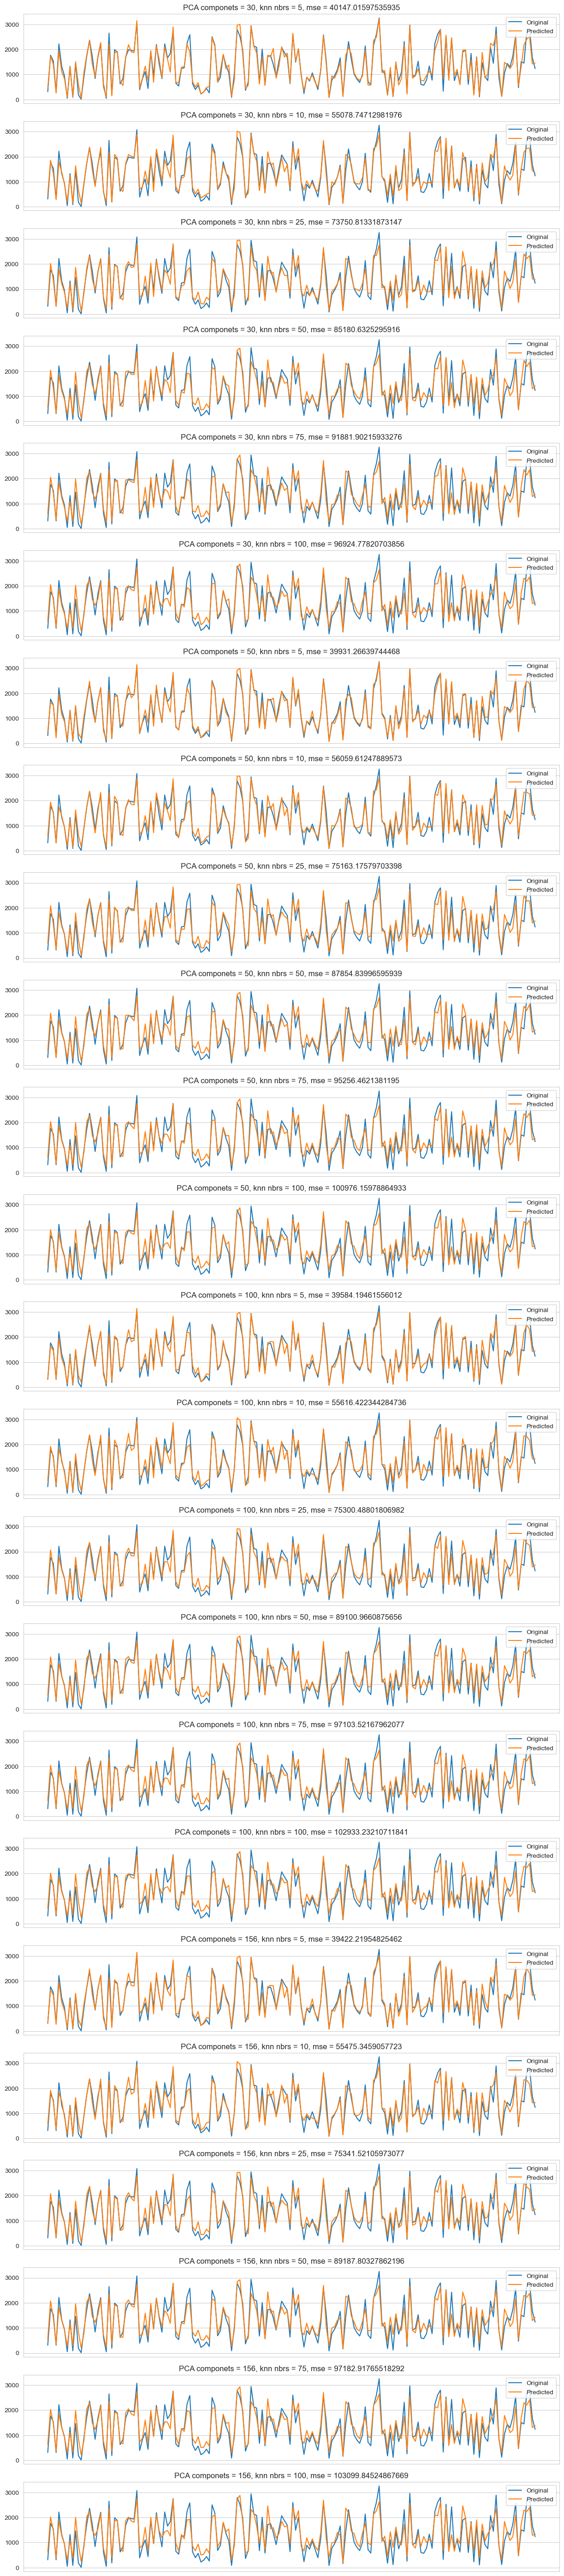

In [12]:
fig, ax = plt.subplots(len(pca_comps)*len(n_nbrs), 1, figsize=(15, 72))
for i in range(len(pca_comps)*len(n_nbrs)):
    ax[i].plot(df_test[0:-1:50]['time'], df_test[0:-1:50]['Wind'], label = 'Original')
    ax[i].plot(df_test[0:-1:50]['time'], preds[i][0:-1:50], label = 'Predicted')
    ax[i].set_title(f"PCA componets = {dic[i][0]}, knn nbrs = {dic[i][1]}, mse = {mses[i]}")
    ax[i].legend(loc='upper right')
    ax[i].tick_params(axis='x', rotation = 45)
    ax[i].set_xticks([])

plt.show()

### kNN with day totals

In this case, we split carefully by clubbing the hours of each day separately.

In [ ]:
# training on years 2019,2020,2021 and validating on 2022
df_train = df[df['Year'] != 2022]
df_test = df[df['Year'] == 2022]

### Making a baseline model prediction for the validation set as best as I understood
Question about the baseline model: what do we exactly mean?

In [50]:
def all_days_of_year(year):
    start_date = pd.Timestamp(year=year, month=1, day= 1)
    end_date = pd.Timestamp(year=year, month=12, day=31)
    return [x.strftime('%m-%d') for x in pd.date_range(start=start_date, end=end_date, freq= 'd')]
def BaselinePredict(year):
    day_list = all_days_of_year(year)
    preds = {}
    for day in day_list:
        df_day = df_test[df_test['MonthDay'] == day]
        preds[day] = sum(np.array(df_day.Wind))
    return(preds)

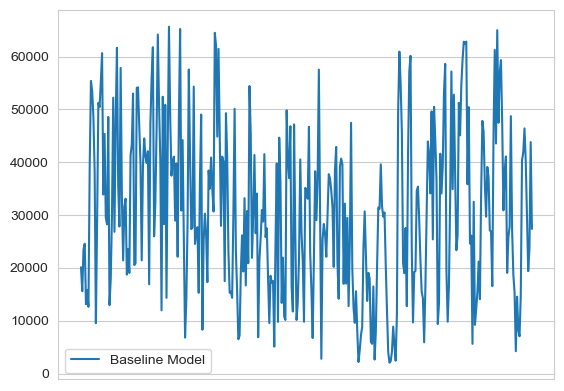

In [51]:
baseline_pred = BaselinePredict(2022)
plt.plot(baseline_pred.keys(), baseline_pred.values(), label = 'Baseline Model')
plt.xticks([])
plt.legend()

#### Actually trying to make a kNN model using daily totals

In [57]:
test_year = 2022
days_list = all_days_of_year(test_year)
no_days = len(days_list)
pca_comps = [30,50,100, 156 ]
n_nbrs = [5, 10, 25, 50, 75, 100]
preds = np.zeros(shape=(len(pca_comps)*len(n_nbrs),no_days))
dic = {}
for i in range(len(pca_comps)):
    for j in range(len(n_nbrs)):
        dic[len(n_nbrs)*i + j] = (pca_comps[i], n_nbrs[j])
for i in range(len(pca_comps)):
    for j in range(len(n_nbrs)):
        pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components= pca_comps[i]))])
        pipe.fit(df_train[features])

        pca_train = pipe.transform(df_train[features])
        pca_test = pipe.transform(df_test[features])


        knn = KNeighborsRegressor(n_neighbors=n_nbrs[j])
        knn.fit(pca_train, df_train.Wind)

        pred = knn.predict(pca_test)
        preds[len(n_nbrs)*i + j,: ] = [sum(pred[24*i:24*(i+1)]) for i in range(no_days)]

In [66]:
from sklearn.metrics import mean_absolute_percentage_error

In [73]:
mses_baseline = [mean_absolute_percentage_error(y_true= [float(x) for x in baseline_pred.values()], y_pred= preds[i]) for i in range(len(pca_comps)*len(n_nbrs))]
print(f"Best combination in terms of mean_absolute_percentage_error over the whole 25% test set: pca_comp = {dic[mses_baseline.index(min(mses_baseline))][0]}, no of knn nbrs = {dic[mses.index(min(mses))][1]}")
print(f"Best mean absolute percentage error for the checked combinations {min(mses_baseline)*100}%")

Best combination in terms of mean_absolute_percentage_error over the whole 25% test set: pca_comp = 30, no of knn nbrs = 5
Best mean absolute percentage error for the checked combinations 21.13715548579933%


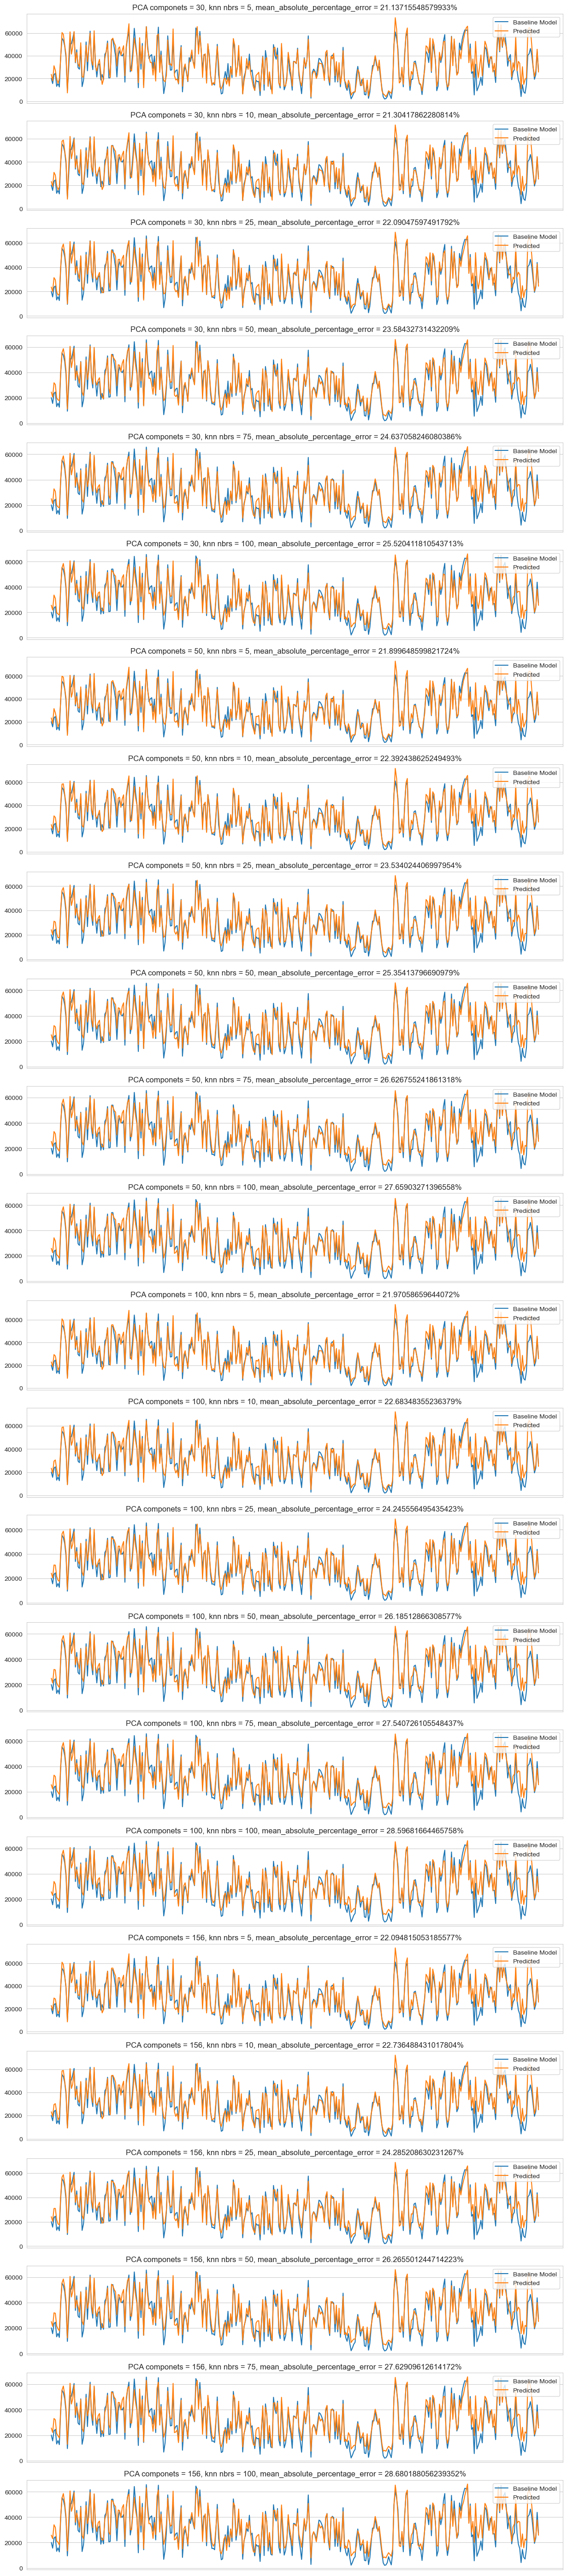

In [ ]:
fig, ax = plt.subplots(len(pca_comps)*len(n_nbrs), 1, figsize=(15, 72))
for i in range(len(pca_comps)*len(n_nbrs)):
    ax[i].plot(baseline_pred.keys(), baseline_pred.values(), label = 'Baseline Model')
    ax[i].plot(days_list, preds[i], label = 'Predicted')
    ax[i].set_title(f"PCA componets = {dic[i][0]}, knn nbrs = {dic[i][1]}, mean_absolute_percentage_error from the baseline = {mses_baseline[i]*100}%")
    ax[i].legend(loc='upper right')
    ax[i].tick_params(axis='x', rotation = 45)
    ax[i].set_xticks([])

plt.show()